In [1]:
import sys
import json 
import os
sys.path.append("../")
from scipy import integrate
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp2d
import obspy
import numpy as np 
import matplotlib.pyplot as plt
from TorchInversion.propagators import Acoustic_Simulation
from TorchInversion.utils import source_wavelet,set_damp,dictToObj,numpy2tensor,numpy2list
from TorchInversion.plots import plot_model,plot_wavelet,plot_dampRegion,plot_observeSystem,wiggle
from TorchInversion.optimizer import Optimization

In [2]:
save_path = "./data/04_Marmousi2/AD_shotInMiddle"

if not os.path.exists(os.path.join(save_path,"model/True")):
    os.makedirs(os.path.join(save_path,"model/True"))

if not os.path.exists(os.path.join(save_path,"grad")):
    os.makedirs(os.path.join(save_path,"grad"))

if not os.path.exists(os.path.join(save_path,"obs/figure")):
    os.makedirs(os.path.join(save_path,"obs/figure"))

if not os.path.exists(os.path.join(save_path,"syn/figure")):
    os.makedirs(os.path.join(save_path,"syn/figure"))

In [3]:
#######################################
#              模型设置
#######################################
# Model parameters
nx , ny = [80, 179]
nt , dt = [1545, 0.00317]
pml, fs   = [15,  1]
nx_pml = nx+2*pml
ny_pml = ny+2*pml
dx, dy = [44.7619, 44.1679]

In [4]:
def extract_data(meta):
    data = []
    for trace in meta:
        data.append(trace.data)
    return np.array(data)


def load_marmousi_model():
    in_dir = os.path.join(save_path,"model/True/")
    if not os.path.exists(os.path.join(in_dir, "vp_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/vp_marmousi-ii.segy.gz", in_dir))
    if not os.path.exists(os.path.join(in_dir, "vs_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/vs_marmousi-ii.segy.gz", in_dir))
    if not os.path.exists(os.path.join(in_dir, "density_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/density_marmousi-ii.segy.gz", in_dir))
    meta = obspy.read(os.path.join(in_dir, "vs_marmousi-ii.segy.gz"), format='segy')
    vs = extract_data(meta) * 1e3 #m/s^2
    meta = obspy.read(os.path.join(in_dir, "vp_marmousi-ii.segy.gz"), format='segy')
    vp = extract_data(meta) * 1e3 #m/s^2
    meta = obspy.read(os.path.join(in_dir, "density_marmousi-ii.segy.gz"), format='segy')
    rho = extract_data(meta) * 1e3 #kg/m^3
    
    x_range = [0, 17000] #m
    y_range = [0, 3500] #m
    nx, ny = vp.shape
    x = np.linspace(x_range[0], x_range[1], nx)
    y = np.linspace(y_range[0], y_range[1], ny)

    marmousi_model = {}
    marmousi_model['vp'] = vp
    marmousi_model['vs'] = vs
    marmousi_model['rho'] = rho
    marmousi_model['x'] = x
    marmousi_model['y'] = y
    marmousi_model['dx'] = x[1] - x[0]
    marmousi_model['dy'] = y[1] - y[0]
    
    return marmousi_model

def resample_model(x, y, model):
    
    vs = interp2d(model['y'], model['x'], model['vs'], kind='cubic')(y, x)
    vp = interp2d(model['y'], model['x'], model['vp'], kind='cubic')(y, x)
    rho = interp2d(model['y'], model['x'], model['rho'], kind='cubic')(y, x)
    
    new_model = {}
    new_model['vp'] = vp
    new_model['vs'] = vs
    new_model['rho'] = rho
    new_model['x'] = x
    new_model['y'] = y
    new_model['dx'] = x[1] - x[0]
    new_model['dy'] = y[1] - y[0]
    
    return new_model

marmousi_model = load_marmousi_model()
x_range = [5000, 13000]
y_range = [0, 3500]
x = np.arange(x_range[0], x_range[1], dx)
y = np.arange(y_range[0], y_range[1], dy)
model = resample_model(x, y, marmousi_model)

/tmp/ipykernel_3861642/3088845911.py:42: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  vs = interp2d(model['y'], model['x'], model['vs'], kind='cubic')(y, x)
/tmp/ipykernel_3861642/3088845911.py:42: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In n

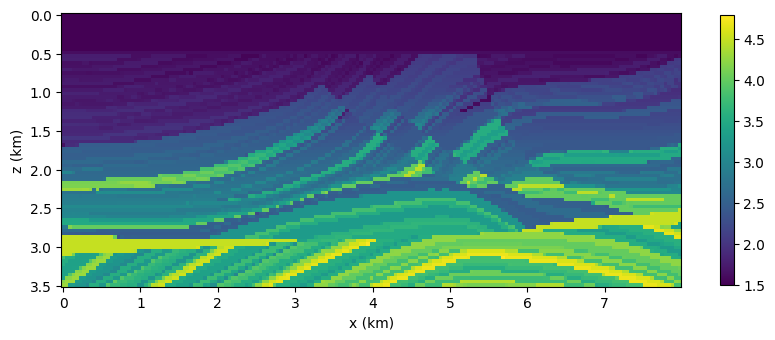

In [5]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, model['vp'].T/1e3)
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.show()

In [6]:
v = model['vp'].T
# rho = model["rho"].T
rho = np.power(v, 0.25) * 310

In [7]:
#######################################
#             子波设置
#######################################
#Source wavelet
f0 = 5 #Domain frequency
src = source_wavelet(nt, dt, f0, 'Ricker') #Ricker wavelet
st = integrate.cumtrapz(src, axis=-1, initial=0) #Integrate
tlist = np.arange(nt)*dt

#######################################
#              吸收边界设置
#######################################
#PML coefficient
vmax = v.max()
vmin =  v.min()
damp_global = set_damp(vmax,nx_pml,ny_pml,pml,dx)

#######################################
#              炮和检波器设置
#######################################
# Source location
# src_x = np.array([nx-np.random.randint(5,12) for i in range(0,ny,25)]) + pml 
src_x = np.array([50 for i in range(10,ny-5,3)]) + pml 
src_y = np.array([i for i in range(10,ny-5,3)]) + pml
src_n = src_x.shape[0]

# free surface
mask =  (src_x==pml)
src_x[mask] = src_x[mask] + 1
#Receiver location
rcv_x = [12 for i in range(0,ny,5)]
rcv_y = [j+1 for j in range(0,ny-1,5)]
rcv_n = np.size(rcv_y)
rcv_x = np.array(rcv_x)
rcv_y = np.array(rcv_y)

In [8]:
#######################################
#              参数整理
#######################################
# modeling parameters
param = {
    "nx":nx,"ny":ny,
    "dx":dx,"dy":dy,
    "nt":nt,"dt":dt,
    "pml":pml,"fs":fs,
    "nx_pml":nx_pml,"ny_pml":ny_pml,
    "vmax":vmax,"vmin":vmin
}
param = dictToObj(param)

# velocity model
vel_model ={
    "v":v,
    "rho":rho,
    "damp_global":damp_global
}
vel_model= dictToObj(vel_model)

# source
acoustic_src = {
    "f0":f0,
    "src_x":src_x,
    "src_y":src_y,
    "src_n":src_n,
    "stf_val":st,
    "stf_t":tlist
}

acoustic_src = dictToObj(acoustic_src)

# receiver
acoustic_rcv = {
    'rcv_x':rcv_x,
    'rcv_y':rcv_y,
    'rcv_n':rcv_n
}
acoustic_rcv = dictToObj(acoustic_rcv)

In [9]:
import json 
param_save = {
    "nx":nx,"ny":ny,
    "dx":dx,"dy":dy,
    "nt":nt,"dt":dt,
    "pml":pml,"fs":fs,
    "nx_pml":nx_pml,"ny_pml":ny_pml,
}

model_save={
    "v":numpy2list(v),
    "rho":numpy2list(rho),
    "damp_global":numpy2list(damp_global),
    "src_x":numpy2list(src_x),
    "src_y":numpy2list(src_y),
    "src_n":src_n,
    "stf_val":numpy2list(acoustic_src.stf_val),
    "stf_t":numpy2list(tlist),
    'rcv_x':numpy2list(rcv_x),
    'rcv_y':numpy2list(rcv_y),
    'rcv_n':rcv_n
}
with open(os.path.join(save_path,"model/param_true.json"),'w') as f:
    json.dump(param_save,f)
with open(os.path.join(save_path,"model/model_true.json"),'w') as f:
    json.dump(model_save,f)

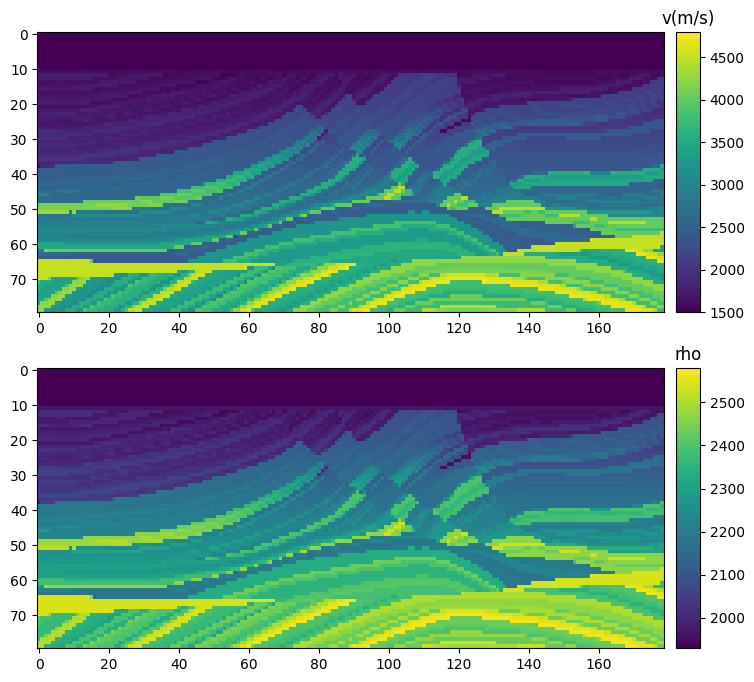

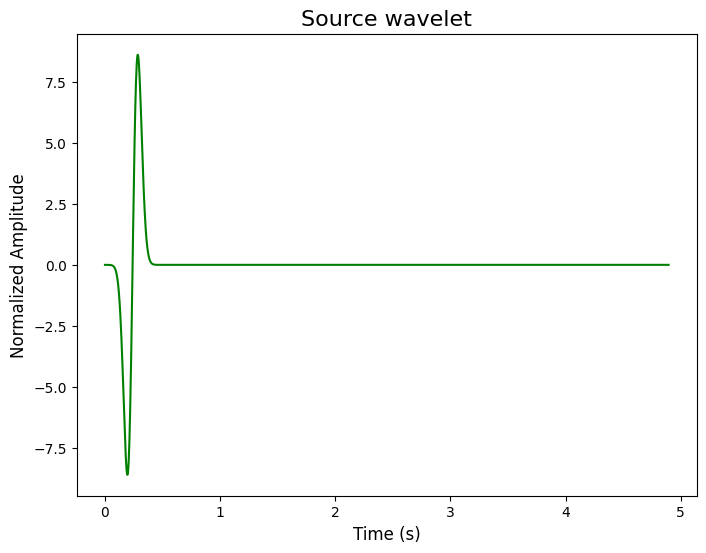

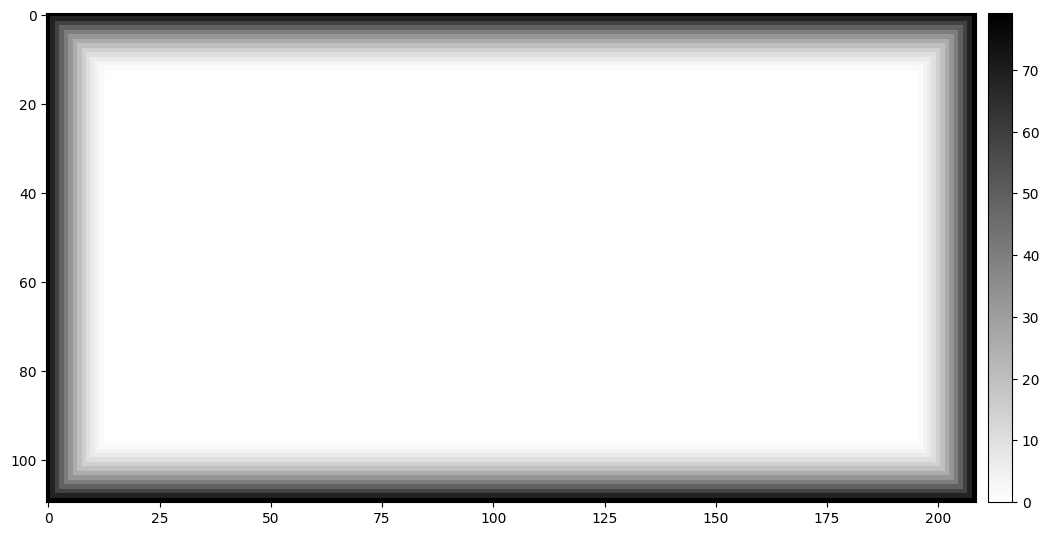

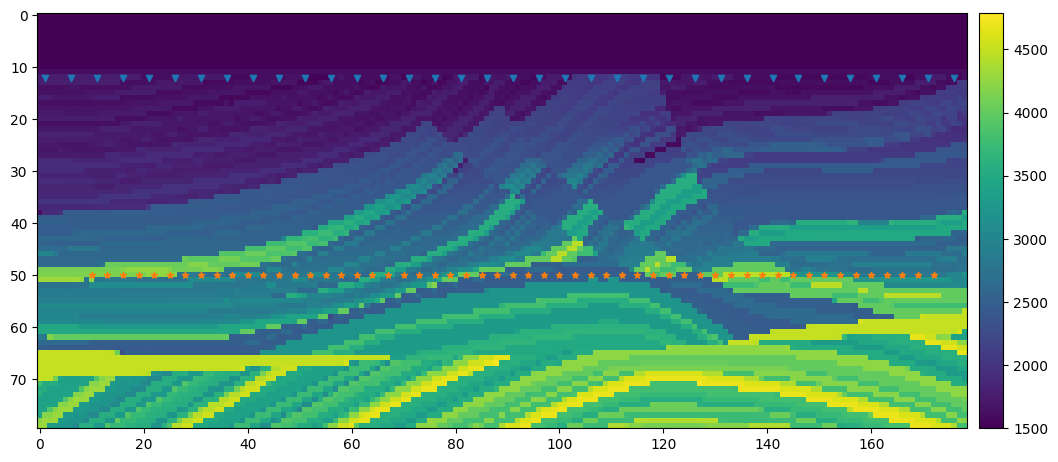

In [10]:
#Plot
plot_model(vel_model,save_path=os.path.join(save_path,"model/True/model.png"),show=True)
plot_wavelet(acoustic_src,save_path=os.path.join(save_path,"model/True/ricker.png"),show=True)
plot_dampRegion(vel_model,save_path=os.path.join(save_path,"model/True/damp_global.png"),show=True)
plot_observeSystem(param,vel_model,acoustic_src,acoustic_rcv,save_path=os.path.join(save_path,"model/True/observed_system.png"),show=True)

In [11]:
#######################################
#         Forward simulation
#######################################
device = "cuda:0"
acoustic_sim = Acoustic_Simulation(param,vel_model,acoustic_src,acoustic_rcv,device=device)
# input model
rho = numpy2tensor(rho).to(device)
v = numpy2tensor(v).to(device)
csg = acoustic_sim.forward(v,rho)
# save the result
if device == 'cpu':
    csg = csg.detach().numpy()
else:
    csg = csg.cpu().detach().numpy()

np.savez(os.path.join(save_path,"obs/obs.npz"),obs_data = csg)

# for i in range(src_n):
#     # np.savetxt(os.path.join(save_path,"obs/s{}_obs.txt".format(i)),csg[i])
#     wiggle(csg[i],np.arange(nt)*dt,save_path=os.path.join(save_path,"obs/figure/s{}_obs.png".format(i)))

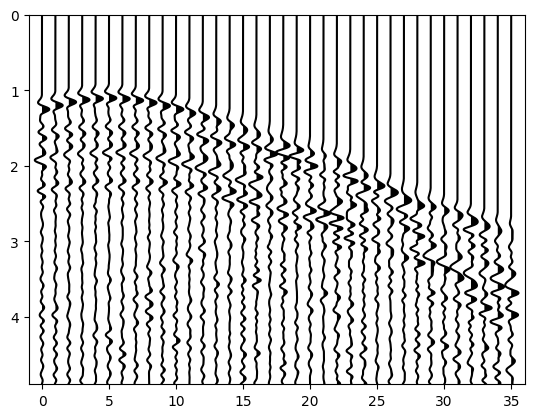

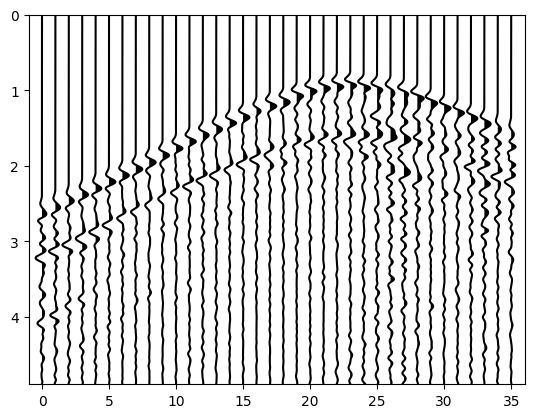

In [12]:
wiggle(csg[5],np.arange(nt)*dt,show=True)
wiggle(csg[36],np.arange(nt)*dt,show=True)

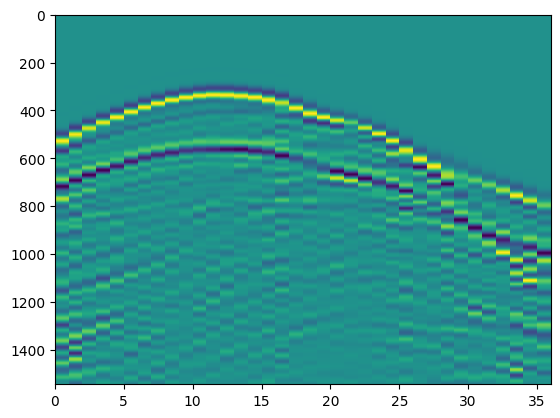

In [13]:
plt.figure()
plt.pcolormesh(csg[15])
plt.gca().invert_yaxis()
plt.show()